In [40]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [41]:
url = "nvidia/nvidia_power_pretrain.csv"
df_orig = pd.read_csv(url)

In [34]:
#it is using one gpu only

In [42]:
df = df_orig.loc[df_orig[" utilization.gpu [%]"] > 0] #isolating training 
df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]

/Users/shivangi/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [43]:
time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
#print("Total time in seconds: {}".format(time_interval.total_seconds()))
total_time = time_interval.total_seconds()
print("seconds: {}".format(total_time))
print ("hours: {}".format(total_time/3600))

seconds: 5991.57
hours: 1.6643249999999998


In [44]:
mean_power =df[' power.draw [W]'].mean() 
total_power = mean_power * total_time
gpu_util = df[' utilization.gpu [%]'].mean()
memory_util = df[' utilization.memory [%]'].mean()
memory_used = df[' memory.used [MiB]'].mean()

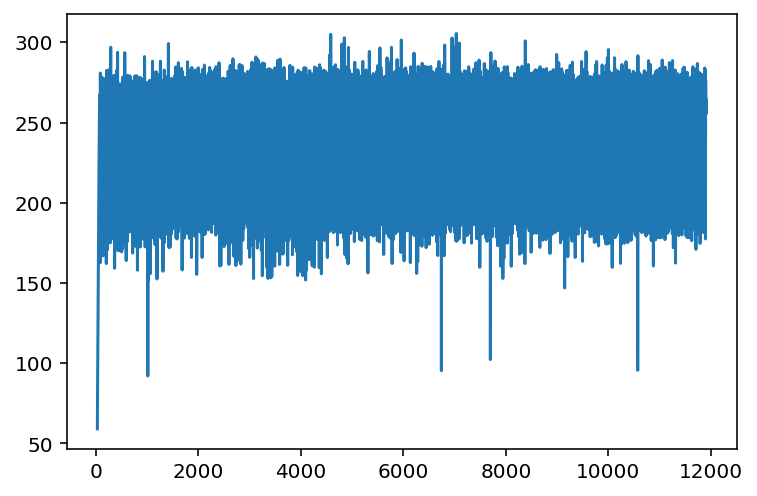

In [45]:
df[" power.draw [W]"].plot()

In [46]:
print("total power consumption: {}".format(total_power))

total power consumption: 1516541.3808476038


In [47]:
total_power / (1000 * 60 *60)

0.42126149467988994

As per output from run_pretraining
global step per second = 2.12....
examples/sec = global step * batch size = 67/68
the dataset has 101103 instances
time to process = 101103 / 67
per epoch

In [49]:
estimated_time = 101103 /67
total_est_time = estimated_time * 3
print(total_est_time)

4527.0
